<a href="https://colab.research.google.com/github/Ravi-ranjan1801/CUDA-Lab/blob/main/cuda_lab_03_mat_add%26mul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%writefile matrix_add.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <chrono>

using namespace std::chrono;

/* ================= GPU KERNEL ================= */
__global__ void matrixAddGPU(int *A, int *B, int *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        int idx = row * N + col;
        C[idx] = A[idx] + B[idx];
    }
}

/* ================= CPU FUNCTION ================= */
void matrixAddCPU(int *A, int *B, int *C, int N) {
    for (int i = 0; i < N * N; i++) {
        C[i] = A[i] + B[i];
    }
}

int main(int argc, char *argv[]) {

    int N = atoi(argv[1]);
    int size = N * N * sizeof(int);

    /* Host memory */
    int *h_A = (int *)malloc(size);
    int *h_B = (int *)malloc(size);
    int *h_C = (int *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = 1;
        h_B[i] = 2;
    }

    /* ================= CPU TIMING ================= */
    auto cpu_start = high_resolution_clock::now();
    matrixAddCPU(h_A, h_B, h_C, N);
    auto cpu_end = high_resolution_clock::now();

    double cpu_time =
        duration<double, std::milli>(cpu_end - cpu_start).count();

    /* ================= GPU MEMORY ================= */
    int *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    /* ================= AUTO BLOCK SIZE ================= */
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, 0);

    int side = sqrt(prop.maxThreadsPerBlock);
    dim3 block(side, side);
    dim3 grid(
        (N + side - 1) / side,
        (N + side - 1) / side
    );

    /* ================= GPU TIMING ================= */
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixAddGPU<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float gpu_time;
    cudaEventElapsedTime(&gpu_time, start, stop);

    printf("%d %.3f %.3f\n", N, cpu_time, gpu_time);

    /* Cleanup */
    free(h_A); free(h_B); free(h_C);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);

    return 0;
}


Overwriting matrix_add.cu


In [9]:
!nvcc matrix_add.cu -o matrix_add


In [10]:
import subprocess

sizes = [8,16,32,64, 128, 256, 512, 1024, 2048]
cpu_times = []
gpu_times = []

for N in sizes:
    output = subprocess.check_output(["./matrix_add", str(N)])
    N, cpu, gpu = output.decode().split()
    cpu_times.append(float(cpu))
    gpu_times.append(float(gpu))

print("Sizes:", sizes)
print("CPU :", cpu_times)
print("GPU :", gpu_times)


Sizes: [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
CPU : [0.0, 0.001, 0.003, 0.016, 0.091, 0.282, 1.176, 4.678, 19.686]
GPU : [7.758, 7.52, 7.336, 7.503, 7.51, 7.311, 7.951, 7.457, 7.156]


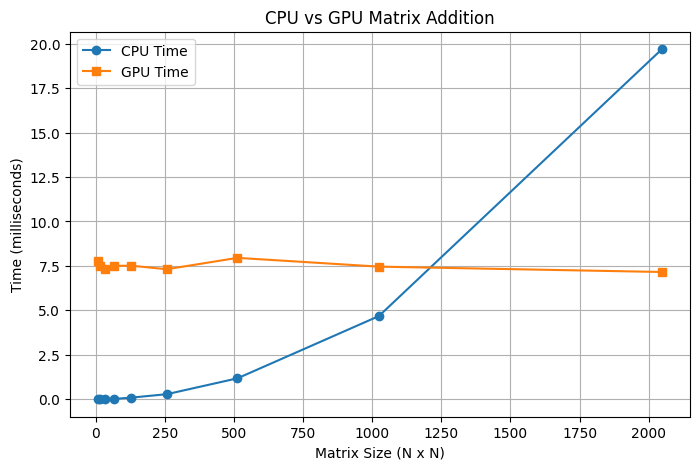

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(sizes, cpu_times, marker='o', label='CPU Time')
plt.plot(sizes, gpu_times, marker='s', label='GPU Time')

plt.xlabel("Matrix Size (N x N)")
plt.ylabel("Time (milliseconds)")
plt.title("CPU vs GPU Matrix Addition")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
%%writefile matrix_mul.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <chrono>

using namespace std::chrono;

__global__ void matrixMulGPU(int *A, int *B, int *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        int sum = 0;
        for (int k = 0; k < N; k++)
            sum += A[row * N + k] * B[k * N + col];
        C[row * N + col] = sum;
    }
}

void matrixMulCPU(int *A, int *B, int *C, int N) {
    for (int i = 0; i < N; i++)
        for (int j = 0; j < N; j++) {
            int sum = 0;
            for (int k = 0; k < N; k++)
                sum += A[i * N + k] * B[k * N + j];
            C[i * N + j] = sum;
        }
}

int main(int argc, char *argv[]) {

    int N = atoi(argv[1]);
    int size = N * N * sizeof(int);

    int *h_A = (int *)malloc(size);
    int *h_B = (int *)malloc(size);
    int *h_C = (int *)malloc(size);

    for (int i = 0; i < N * N; i++)
        h_A[i] = h_B[i] = 1;

    // CPU timing
    auto cpu_start = high_resolution_clock::now();
    matrixMulCPU(h_A, h_B, h_C, N);
    auto cpu_end = high_resolution_clock::now();
    double cpu_time = duration<double, std::milli>(cpu_end - cpu_start).count();

    int *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, 0);

    int side = sqrt(prop.maxThreadsPerBlock);
    dim3 block(side, side);
    dim3 grid((N + side - 1) / side, (N + side - 1) / side);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMulGPU<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float gpu_time;
    cudaEventElapsedTime(&gpu_time, start, stop);

    printf("%d %.3f %.3f\n", N, cpu_time, gpu_time);

    free(h_A); free(h_B); free(h_C);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);

    return 0;
}


Overwriting matrix_mul.cu


In [13]:
!nvcc matrix_mul.cu -o matrix_mul

In [23]:
import subprocess

sizes = [4,8,16,32,64,112, 128, 196]
cpu_times = []
gpu_times = []

for N in sizes:
    output = subprocess.check_output(["./matrix_mul", str(N)])
    N, cpu, gpu = output.decode().split()
    cpu_times.append(float(cpu))
    gpu_times.append(float(gpu))

print("Sizes     :", sizes)
print("CPU times :", cpu_times)
print("GPU times :", gpu_times)


Sizes     : [4, 8, 16, 32, 64, 112, 128, 196]
CPU times : [0.001, 0.002, 0.011, 0.15, 0.735, 4.181, 13.691, 39.643]
GPU times : [7.669, 9.533, 7.858, 7.428, 7.701, 11.959, 11.412, 11.309]


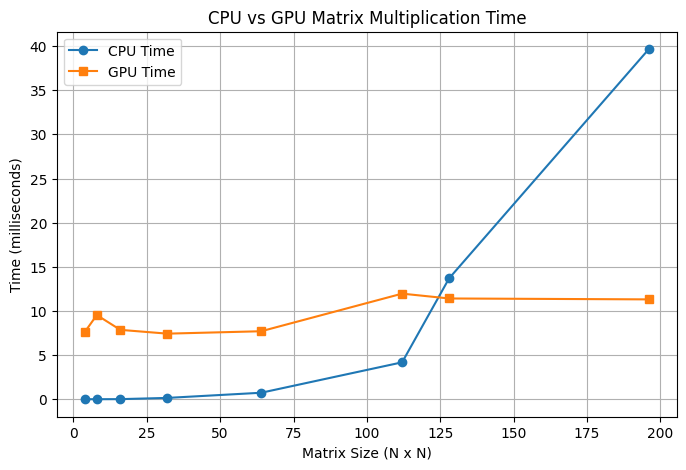

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(sizes, cpu_times, marker='o', label='CPU Time')
plt.plot(sizes, gpu_times, marker='s', label='GPU Time')

plt.xlabel("Matrix Size (N x N)")
plt.ylabel("Time (milliseconds)")
plt.title("CPU vs GPU Matrix Multiplication Time")
plt.legend()
plt.grid(True)
plt.show()
